In this code, we try variational autoencoder on MNIST Dataset.

In [17]:
# IMPORT NECESSARY PACKAGES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# for random splitting
from sklearn.model_selection import train_test_split

# import Keras classes
import keras
from keras.datasets import mnist
from keras.models import Model
from keras import layers
from keras.layers.core import Dense, Dropout, Activation
import keras.optimizers as koptim
from keras.utils import np_utils
from keras import regularizers
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

# CHECK GPU
print(K.tensorflow_backend._get_available_gpus())


['/job:localhost/replica:0/task:0/device:GPU:0']


Define Hyperparameters

In [3]:
np.random.seed(237)

# network and training hyperpameters
EPOCHS = 7
BATCH_SIZE = 16
VERBOSE = 1
CLASSES = 10  # number of outputs = number of digits
HIDDEN_NODES = 128
VALIDATION_SPLIT=0.2  # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.3  # drop 30% of the nodes for dropout
LEARN_RATE = 0.0001
LAMBDA = 0
INPUT_SHAPE = (28, 28, 1)
LATENT_DIM = 2

# select optimizer type
# GD: gradient descent
# SGD: Stocastic Gradient Descent
# RMS: RMSProp optimizer
# ADAM: Adam optimizer
OPTIMIZER_TYPE = "SGD"
if(OPTIMIZER_TYPE == "SGD"):
    OPTIMIZER = koptim.SGD()
elif(OPTIMIZER_TYPE == "RMS"):
    # keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    OPTIMIZER = koptim.RMSprop()
elif(OPTIMIZER_TYPE == "ADAM"):
    # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    OPTIMIZER = koptim.Adam(lr = LEARN_RATE)

Load MNIST Dataset. Keras provides support for MNIST dataset.
The dataset has 60k training and 10k test images each of size 28x28=784 pixels

In [4]:
# data: shuffled and split between train and test sets
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()
#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
print("Original Data Shape")
print("Training Data X: ", np.shape(x_train_orig))
print("Training Data Y: ", np.shape(y_train_orig))
print("Testing Data X: ", np.shape(x_test_orig))
print("Testing Data Y: ", np.shape(y_test_orig))

# reshape data to flatten images
# X_train_reshaped = x_train_orig.reshape(60000, RESHAPED)
# X_test_reshaped = x_test_orig.reshape(10000, RESHAPED)

# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
X_train_reshaped = x_train_orig[:, :, :, np.newaxis]
X_test_reshaped = x_test_orig[:, :, :, np.newaxis]


# convert data to float type
X_train_reshaped = X_train_reshaped.astype('float32')
X_test_reshaped = X_test_reshaped.astype('float32')

# reshaped data
print("\nReshaped Data")
print("Reshaped Training Data X: ", np.shape(X_train_reshaped))
print("Reshaped Training Data Y: ", np.shape(y_train_orig))
print("Reshaped Testing Data X: ", np.shape(X_test_reshaped))
print("Reshaped Testing Data Y: ", np.shape(y_test_orig))

# print("\nSample Input")
# for i in range(5):
#     print(y_train_orig[i], X_train_reshaped[i,:])

Original Data Shape
Training Data X:  (60000, 28, 28)
Training Data Y:  (60000,)
Testing Data X:  (10000, 28, 28)
Testing Data Y:  (10000,)

Reshaped Data
Reshaped Training Data X:  (60000, 28, 28, 1)
Reshaped Training Data Y:  (60000,)
Reshaped Testing Data X:  (10000, 28, 28, 1)
Reshaped Testing Data Y:  (10000,)


**Combine Train and Test set into one**: Since we are training Variational Autoencoder, we do not desire a separate test set to evaluate our model. Infact, the more data we have for training the better it should it should perform.  
**Split data into train and validation**: Because we train the model by minimizing a loss function, it is a good practice to evaluate the performance of our model after every epoch

In [5]:
# combine train and test data. We do not need to combine the labels as they are not used
x_train_data = np.concatenate((X_train_reshaped, X_test_reshaped))
y_train_data = np.concatenate((y_train_orig, y_test_orig))
print("Train Data Shape", np.shape(x_train_data))

# normalize data
x_train_data = x_train_data/255.0

# split train into train and validation
X_train, X_val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=VALIDATION_SPLIT)
print("\nSplit Data Shape")
print("X_train: ", np.shape(X_train))
print("X_val:", np.shape(X_val))

Train Data Shape (70000, 28, 28, 1)

Split Data Shape
X_train:  (56000, 28, 28, 1)
X_val: (14000, 28, 28, 1)


*OPTIONAL
Visualizes some traning images

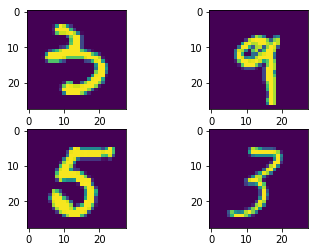

In [6]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13, :, :, 0])

plt.subplot(222)
plt.imshow(X_train[690, :, :, 0])

plt.subplot(223)
plt.imshow(X_train[2375, :, :, 0])

plt.subplot(224)
plt.imshow(X_train[42013, :, :, 0])
plt.show()

**MODEL CONSTRUCTION**
We now construct the model for VAE  
The VAE has 3 major components:  
1) Encoder Model: Learns the destribution (mean and variance) of the data  
2) Sampling Function: Which samples from the learned distribution  
3) Decoder Model: Converts the sample chosen in #2 back to the image  
  
Both the Encoder model and Decoder model will be a Conv. Neural Net.  
For Encoder Model, notice that the last layer is split into two output layers, one for the latent distribution mean (z_mu) and the other for its variance (z_log_sigma).

In [7]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], LATENT_DIM),mean=0., stddev=1.)
    # print(K.int_shape(epsilon))
    return z_mu + K.exp(z_log_sigma) * epsilon


# ENCODER
input_img = keras.Input(shape=INPUT_SHAPE)

# layer1
x = layers.Conv2D(32, 3,
          padding='same', 
          activation='relu')(input_img)
# layer2
x = layers.Conv2D(64, 3,
          padding='same', 
          activation='relu',
          strides=(2, 2))(x)
# layer3
x = layers.Conv2D(64, 3,
          padding='same', 
          activation='relu')(x)
# layer4
x = layers.Conv2D(64, 3,
          padding='same', 
          activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)
print("Encoder shape before flattening: ", shape_before_flattening)

# layer5
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# layer6
z_mu = layers.Dense(LATENT_DIM)(x)
z_log_sigma = layers.Dense(LATENT_DIM)(x)

encoder = Model(input_img, z_mu)

# SAMPLING
# Sample from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])
print("sampled latent space dimentions: ", K.int_shape(z))

# DECODER
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# print(np.prod(shape_before_flattening[1:]))
x = layers.Dense(np.prod(shape_before_flattening[1:]),
             activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement: This is done because decoder will be used seperately to generate images
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
# decoder takes z as input
z_decoded = decoder(z)

# apply the custom loss to the input images and the decoded latent distribution sample
# Loss function is added as a layer. Thus  Y is the complete training model starting from
# imput_img -> encoder -> sampling -> decoder -> loss minimize
y = CustomVariationalLayer()([input_img, z_decoded])

# Make a complete model
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Encoder shape before flattening:  (None, 14, 14, 64)
sampled latent space dimentions:  (None, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________

In [13]:
vae.load_weights('vae_weights.h5')
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, None))


Train on 56000 samples, validate on 14000 samples
Epoch 1/7
56000/56000 [==============================] - 28s 502us/step - loss: 0.1828 - val_loss: 0.1828
Epoch 2/7
56000/56000 [==============================] - 27s 490us/step - loss: 0.1822 - val_loss: 0.1825
Epoch 3/7
56000/56000 [==============================] - 27s 483us/step - loss: 0.1817 - val_loss: 0.1829
Epoch 4/7
56000/56000 [==============================] - 29s 523us/step - loss: 0.1811 - val_loss: 0.1820
Epoch 5/7
56000/56000 [==============================] - 30s 527us/step - loss: 0.1806 - val_loss: 0.1810
Epoch 6/7
56000/56000 [==============================] - 28s 505us/step - loss: 0.1803 - val_loss: 0.1816
Epoch 7/7
56000/56000 [==============================] - 28s 507us/step - loss: 0.1799 - val_loss: 0.1806


In [14]:
# SAVE WEIGHTS
encoder.save_weights('vae_encoder.h5')
decoder.save_weights('vae_decoder.h5')
vae.save_weights('vae_weights.h5')

Once the training is completed, the encoded values will be able to represent each digit with separable boundaries. This can be varified by plotting the encoded values for each digit in a scatter plot

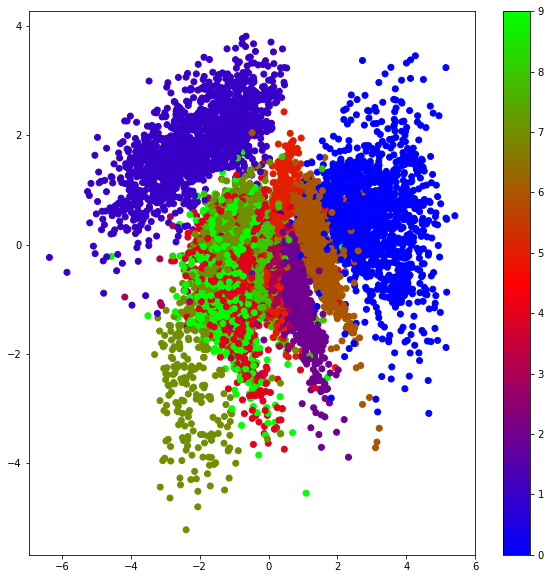

In [15]:
x_val_encoded = encoder.predict(X_val, batch_size=BATCH_SIZE)
plt.figure(figsize=(10, 10))
plt.scatter(x_val_encoded[:, 0], x_val_encoded[:, 1], c=Y_Val, cmap='brg')
plt.colorbar()
plt.show()

Generate Samples

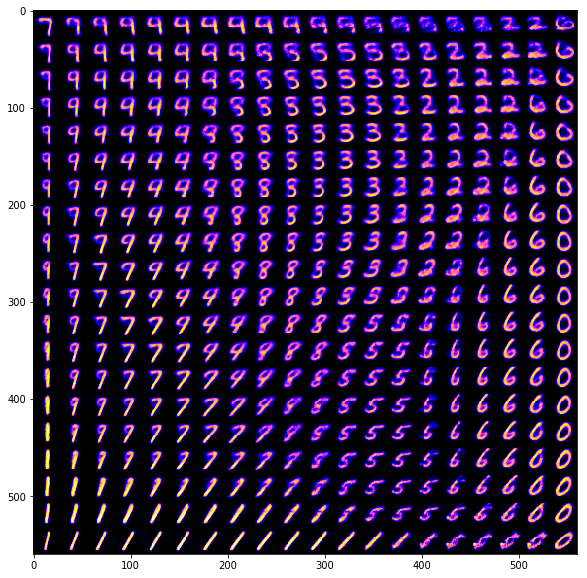

In [21]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, BATCH_SIZE).reshape(BATCH_SIZE, 2)
        x_decoded = decoder.predict(z_sample, batch_size=BATCH_SIZE)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  